# Data Acquisition

In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [2]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)


Mounted at /content/drive


In [3]:
import os
import pandas as pd
from tabulate import tabulate
from tqdm import tqdm
import time
import torch
import multiprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib



def save_fold_metrics_to_excel(results, output_dir=f'{GDRIVE_DATA_DIR}RF_fold_metrics'):
    """Saves validation metrics and hyperparameters for each fold to separate
       sheets in an Excel file, with confusion matrix elements as columns.

    Args:
        results (list): List of dictionaries, each containing fold results.
        output_dir (str, optional): Directory to save the Excel file.
                                     Defaults to './RF_tables'.
    """

    os.makedirs(output_dir, exist_ok=True)
    excel_path = os.path.join(output_dir, 'fold_metrics.xlsx')

    # Define the order of columns
    column_order = [
        'Accuracy (Train)', 'Accuracy (Val)',
        'AUC (Train)', 'AUC (Val)',
        'Recall (Train)', 'Recall (Val)',
        'Specificity (Train)', 'Specificity (Val)',
        'F1 (Train)', 'F1 (Val)',
        'Precision (Train)', 'Precision (Val)',
        'NPV (Train)', 'NPV (Val)',
        'PPV (Train)', 'PPV (Val)',
        'Macro F1 (Train)', 'Macro F1 (Val)',
        '1:1-TP (Train)', '1:0-FN (Train)', '0:0-TN (Train)', '0:1-FP (Train)',
        '1:1-TP (Val)', '1:0-FN (Val)', '0:0-TN (Val)', '0:1-FP (Val)',
        'Fold Duration',
        # Hyperparameters (GridSearchCV and RandomForestClassifier)
        'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
        'bootstrap', 'max_features', 'class_weight',
        'criterion', 'oob_score', 'random_state', 'n_jobs',
        'verbose', 'cv', 'refit'  # GridSearchCV parameters
    ]

    with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
        for i, fold_data in enumerate(results):
            fold_duration = fold_data.get('Fold Duration', 'N/A')
            sheet_name = f"Fold {i+1}"

            # Extract confusion matrix values
            train_cm = fold_data['Train Confusion Matrix']
            valid_cm = fold_data['Valid Confusion Matrix']

            row_data = {
                'Accuracy (Train)': fold_data['Train']['Accuracy'][0],
                'Accuracy (Val)': fold_data['Valid']['Accuracy'][0],
                'AUC (Train)': fold_data['Train']['AUC'][0],
                'AUC (Val)': fold_data['Valid']['AUC'][0],
                'Recall (Train)': fold_data['Train']['Recall'][0],
                'Recall (Val)': fold_data['Valid']['Recall'][0],
                'Specificity (Train)': fold_data['Train']['Specificity'][0],
                'Specificity (Val)': fold_data['Valid']['Specificity'][0],
                'F1 (Train)': fold_data['Train']['F1'][0],
                'F1 (Val)': fold_data['Valid']['F1'][0],
                'Precision (Train)': fold_data['Train']['Precision'][0],
                'Precision (Val)': fold_data['Valid']['Precision'][0],
                'NPV (Train)': fold_data['Train']['NPV'][0],
                'NPV (Val)': fold_data['Valid']['NPV'][0],
                'PPV (Train)': fold_data['Train']['PPV'][0],
                'PPV (Val)': fold_data['Valid']['PPV'][0],
                '1:1-TP (Train)': train_cm[1][1],
                '1:0-FN (Train)': train_cm[1][0],
                '0:0-TN (Train)': train_cm[0][0],
                '0:1-FP (Train)': train_cm[0][1],
                '1:1-TP (Val)': valid_cm[1][1],
                '1:0-FN (Val)': valid_cm[1][0],
                '0:0-TN (Val)': valid_cm[0][0],
                '0:1-FP (Val)': valid_cm[0][1],
                'Fold Duration': fold_duration
            }

            # Add best hyperparameters from GridSearchCV
            for param_name, param_value in fold_data['Best Params'].items():
                row_data[param_name] = param_value

            # Add fixed parameters from RandomForestClassifier and GridSearchCV
            row_data['criterion'] = 'entropy'  # From RandomForestClassifier
            row_data['oob_score'] = True         # From RandomForestClassifier
            row_data['random_state'] = 42       # From RandomForestClassifier
            row_data['n_jobs'] = -1             # From both
            row_data['verbose'] = 10            # From GridSearchCV
            row_data['cv'] = 5                  # From GridSearchCV
            row_data['refit'] = 'average_precision'  # From GridSearchCV

            all_data = [row_data]

            df = pd.DataFrame(all_data, columns=column_order)
            df.to_excel(writer, sheet_name=sheet_name, index=False)

            all_data = [row_data]  # Create a list containing the row_data

            df = pd.DataFrame(all_data, columns=column_order)
            df.to_excel(writer, sheet_name=sheet_name, index=False)



# ZCR CV

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/utils/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

from sono_cross_val_zcr import CrossValSplit
# help(CrossValSplit)

['__init__.py', 'feature_extraction.py', 'feature_extraction_melspectogram.py', 'framing.py', 'simple_ingestion.py', 'sono_cross_val.py', 'sono_cross_val_zcr.py', 'train_with_zcr.py', 'utils.py', '__pycache__']


# Run at the beginnning

In [6]:
GDRIVE_DATA_DIR = "/content/drive/My Drive/23-24_CE903-SU_team06/dataset/"
print(os.listdir(GDRIVE_DATA_DIR))

['Dataset workflow.csv', 'FE_ZCR_17.feather', 'audio_data_100_test_framing_16Khz.feather', 'audio_data_300_before_framing_16Khz.feather', 'audio_files.7z', 'df_frames_from_save.feather', 'df_from_save_origin.feather', 'RF_fold_metrics', '.ipynb_checkpoints']


In [7]:
# Load FE_ZCR_17.feather
df_ZCR = pd.read_feather(f'{GDRIVE_DATA_DIR}FE_ZCR_17.feather')

# Load df_frames_from_save.Feather
df_frames_from_save = pd.read_feather(f'{GDRIVE_DATA_DIR}df_frames_from_save.feather')

# Load df_from_save_origin.feather
df_from_save = pd.read_feather(f'{GDRIVE_DATA_DIR}df_from_save_origin.feather')

# Test, Train, Val

There are no NaN values in any column of the DataFrame.
NO NANS
Data Normalized
Sono Cross Val Split
 StratifiedKFold(n_splits=5, random_state=6, shuffle=True) 	Total Audio Files: 300


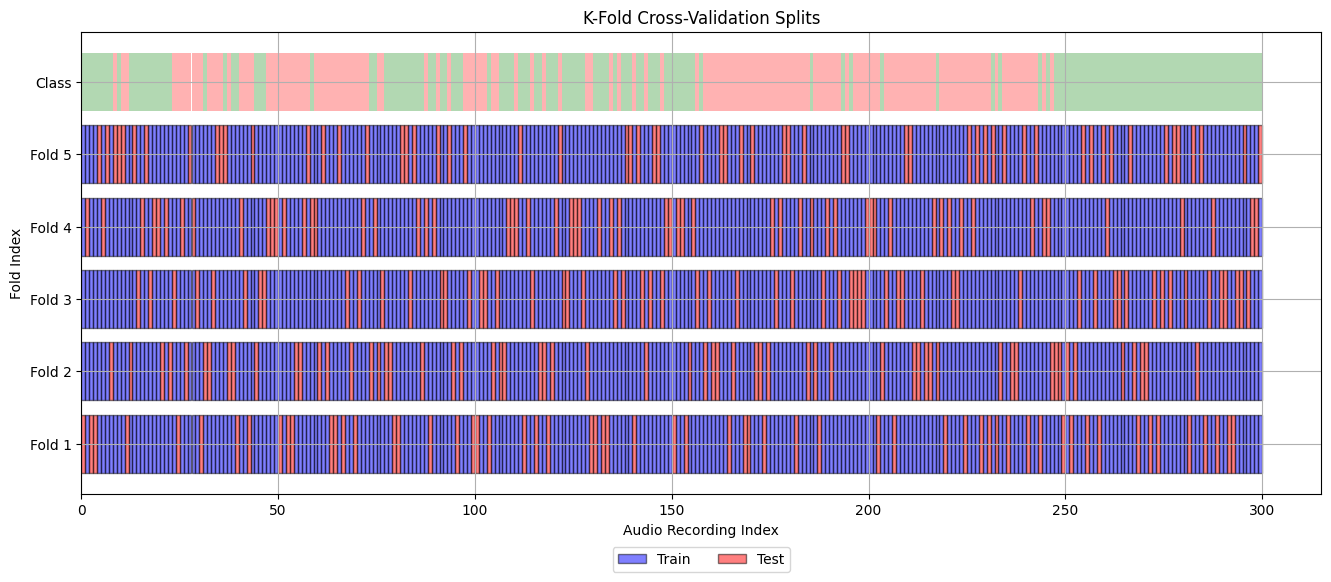

Fold:  1 
-Train:	Frame Size (Dataset): 63315 		Frame Size (CV Split): 63315 		Audio Files: 240
-Test:	Frame Size (Dataset): 19642 		Frame Size (CV Split): 19642 		Audio Files: 60 

Fold:  2 
-Train:	Frame Size (Dataset): 68044 		Frame Size (CV Split): 68044 		Audio Files: 240
-Test:	Frame Size (Dataset): 14913 		Frame Size (CV Split): 14913 		Audio Files: 60 

Fold:  3 
-Train:	Frame Size (Dataset): 69040 		Frame Size (CV Split): 69040 		Audio Files: 240
-Test:	Frame Size (Dataset): 13917 		Frame Size (CV Split): 13917 		Audio Files: 60 

Fold:  4 
-Train:	Frame Size (Dataset): 63593 		Frame Size (CV Split): 63593 		Audio Files: 240
-Test:	Frame Size (Dataset): 19364 		Frame Size (CV Split): 19364 		Audio Files: 60 

Fold:  5 
-Train:	Frame Size (Dataset): 67836 		Frame Size (CV Split): 67836 		Audio Files: 240
-Test:	Frame Size (Dataset): 15121 		Frame Size (CV Split): 15121 		Audio Files: 60 



In [8]:
mean_values = df_ZCR.drop(['amp', 'key'], axis=1).mean()

# Fill NaN values with the mean of each column, excluding 'amp' and 'key'
mean_values = df_ZCR.drop(['amp', 'key'], axis=1).mean()
df_ZCR.fillna(mean_values, inplace=True)

# Check for NaN values in the DataFrame
columns_with_nans = df_ZCR.isna().any()

if columns_with_nans.any():
    print("Columns with NaN values:")
    print(columns_with_nans[columns_with_nans])
else:
    print("There are no NaN values in any column of the DataFrame.")

norm_ignore_cols = ['key', 'amp', 'Frame_index', 'label', 'sf', 'start', 'end']
nan_handling = 'median'  # Or 'mean', 'mode', '0', or 'None'

cv_strat = CrossValSplit(df_single_frame=df_ZCR,
                        non_cough_keys=df_from_save[df_from_save['cough_start_end'].isna()].index,
                        normalize=True,
                        norm_ignore_cols=norm_ignore_cols,
                        nan_handling=nan_handling)
cv_strat_data = cv_strat.cross_val(stratified=True,
                                   shuffle=True,
                                   plot=True,
                                   show_fold_info=True,
                                   )

In [9]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/utils/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

from train_with_zcr import TrainZCR
#help(TrainZCR)
zcr = TrainZCR()

['__init__.py', 'feature_extraction.py', 'feature_extraction_melspectogram.py', 'framing.py', 'simple_ingestion.py', 'sono_cross_val.py', 'sono_cross_val_zcr.py', 'train_with_zcr.py', 'utils.py', '__pycache__']


In [10]:
import torch
from fastai.tabular.data import TabularPandas
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [11]:
from tabulate import tabulate
import joblib
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
from sklearn.inspection import permutation_importance
import multiprocessing

In [13]:
os.makedirs('./RF_models', exist_ok=True)
os.makedirs('./RF_tables', exist_ok=True)
os.makedirs('./RF_plots', exist_ok=True)

metric_names = [
    'Accuracy', 'AUC', 'Recall', 'Specificity',
    'F1', 'Precision', 'NPV', 'PPV',
    'Accuracy', 'AUC',
    'Recall', 'Specificity',
    'F1', 'PPV', 'NPV'
]


# GridSearchCV parameters
param_grid = {
    'n_estimators': [1000],#[100, 200, 300],
    'max_depth': [None],#[None] + list(range(10, 34)),
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'bootstrap': [True],
    'max_features': ['sqrt'], #Auto 'sqrt'
    'class_weight': ['balanced_subsample'],# 'balanced', None,'balanced_subsample'
}

# Define the scoring metrics - OPTIONAL
# scoring = {
#     # 'accuracy': make_scorer(accuracy_score),
#     # 'precision': make_scorer(precision_score, average='weighted'),
#     # 'recall': make_scorer(recall_score, average='weighted'),
#     # 'f1': make_scorer(f1_score, average='weighted'),
#     # 'roc_auc': make_scorer(roc_auc_score, average='weighted', needs_proba=True),
#     'average_precision': make_scorer(average_precision_score, average='weighted', needs_proba=True)
# }



# Create a list of dictionaries where each dictionary represents a row
param_grid_table = []
max_values = max(len(values) for values in param_grid.values())

# Transpose the table for vertical display
transposed_table = []
headers = list(param_grid.keys())
for i in range(max_values):
    row = {}
    for key, values in param_grid.items():
        if i < len(values):
            row[key] = values[i]
        else:
            row[key] = None  # or you can use an empty string ''
    param_grid_table.append(row)
for i, header in enumerate(headers):
    row = [header]
    for param_dict in param_grid_table:
        row.append(param_dict[header])
    transposed_table.append(row)



# Print hyperparameters
print("Hyperparameters:")
print(tabulate(transposed_table, headers=['Parameter'] + [f'Value {i+1}' for i in range(max_values)], tablefmt="grid"))
print()

if torch.cuda.is_available():
    print("CUDA is available.")
    print("GPU(s):", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print("Device {}: {}".format(i, torch.cuda.get_device_name(i)))
else:
    print("CUDA is not available.")
# Get the number of CPU cores
num_cpus = multiprocessing.cpu_count()

print(f"Number of CPU cores available: {num_cpus}")

# Get the number of CPU cores
num_cpus = multiprocessing.cpu_count()

# Define n_jobs for GridSearchCV
n_jobs_grid_search = -1  # or any other value you want to use
print(f'Using {num_cpus} CPUs')

# Set pre_dispatch based on the number of CPU cores
pre_dispatch_value = f'{2 * num_cpus}*n_jobs'

# Train and evaluate models
X, y, feature_names = zcr.get_data_loaders(df_ZCR, cv_strat_data, shuffle=False)
num_folds = len(cv_strat_data)

# Store results in a list of dictionaries
results = []
fold_metrics = []

# Perform hyperparameter tuning with tqdm for progress bar
for i, (train_idx, test_idx) in enumerate(tqdm(cv_strat_data,
                                               desc="Hyperparameter Tuning",
                                               unit="fold")):
    start_time = time.time()
    print(f"Fold {i + 1}/{num_folds}")

    X_train, X_valid = X[train_idx], X[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]

    searcher = GridSearchCV(RandomForestClassifier(
                            criterion='entropy',
                            oob_score=True,
                            random_state=42,
                            n_jobs = -1),
                            param_grid,
                            verbose=10,
                            cv=5,
                            refit='precision',
                            n_jobs=-1,
                            # scoring=scoring,
                            # pre_dispatch = pre_dispatch_value,
                            # return_train_score = True
                            )
    searcher.fit(X_train, y_train)
    best_params = searcher.best_params_

    # Print best hyperparameters in a tabular format
    best_params_table = [[key, value] for key, value in best_params.items()]
    print("Best Hyperparameters:")
    print(tabulate(best_params_table, headers=['Parameter', 'Value'], tablefmt="grid"))

    model = RandomForestClassifier(**best_params)
    model.fit(X_train, y_train)

    model_filename = f'./RF_models/RandomForest_ZCR_Cough-Detection_Fold-{i+1}.pkl'
    joblib.dump(model, model_filename)
    print(f"Model saved: {model_filename}")

    train_preds = model.predict(X_train)
    train_preds_proba = model.predict_proba(X_train)[:, 1]
    valid_preds = model.predict(X_valid)
    valid_preds_proba = model.predict_proba(X_valid)[:, 1]

    train_metrics, train_conf_mat = zcr.get_metrics(y_train, train_preds, train_preds_proba)
    valid_metrics, valid_conf_mat = zcr.get_metrics(y_valid, valid_preds, valid_preds_proba)

    # Append metrics to fold_metrics
    fold_metrics.append(list(train_metrics.values()) + list(valid_metrics.values()))

    # --- Print Fold Results ---
    print(f"--- Fold {i+1} Results ---\n")

    # --- Metrics Grid ---
    metric_table_data = [
        ["Metric", "Train", "Valid"],
        ["Accuracy", f"{train_metrics['Accuracy'][0]:.4f}", f"{valid_metrics['Accuracy'][0]:.4f}"],
        ["AUC", f"{train_metrics['AUC'][0]:.4f}", f"{valid_metrics['AUC'][0]:.4f}"],
        ["Recall", f"{train_metrics['Recall'][0]:.4f}", f"{valid_metrics['Recall'][0]:.4f}"],
        ["Specificity", f"{train_metrics['Specificity'][0]:.4f}", f"{valid_metrics['Specificity'][0]:.4f}"],
        ["F1", f"{train_metrics['F1'][0]:.4f}", f"{valid_metrics['F1'][0]:.4f}"],
        ["Precision", f"{train_metrics['Precision'][0]:.4f}", f"{valid_metrics['Precision'][0]:.4f}"],
        ["NPV", f"{train_metrics['NPV'][0]:.4f}", f"{valid_metrics['NPV'][0]:.4f}"],
        ["PPV", f"{train_metrics['PPV'][0]:.4f}", f"{valid_metrics['PPV'][0]:.4f}"]
        ]
    print(tabulate(metric_table_data, headers="firstrow", tablefmt="grid"))

    # --- Confusion Matrix Grid ---
    print("\nConfusion Matrices:\n")

    print("Train Confusion Matrix:")
    train_conf_mat_data = [
        ["", "Predicted: 1 (Positive)", "Predicted: 0 (Negative)"],
        ["",'TP','FN'],
        ["Actual: 1 (Positive)", train_conf_mat[1][1], train_conf_mat[1][0]],  # TP, FN
        ["Actual: 0 (Negative)", train_conf_mat[0][1], train_conf_mat[0][0]],   # FP, TN
        ["",'FP','TN'],
    ]
    print(tabulate(train_conf_mat_data, headers="firstrow", tablefmt='grid', numalign='right'))
    print("\n") # Add extra line for separation

    print("Valid Confusion Matrix:")
    valid_conf_mat_data = [
        ["", "Predicted: 1 (Positive)", "Predicted: 0 (Negative)"],
        ["",'TP','FN'],
        ["cough: 1 (Positive)(TP)", valid_conf_mat[1][1], valid_conf_mat[1][0]],  # TP, FN
        ["non-cough: 0 (Negative)(FP)", valid_conf_mat[0][1], valid_conf_mat[0][0]],   # FP, TN
        ["",'FP','TN'],

    ]
    print(tabulate(valid_conf_mat_data, headers="firstrow", tablefmt='grid', numalign='right'))
    print("\n")

    results.append({
        'Fold': i + 1,
        'Train': train_metrics,
        'Valid': valid_metrics,
        'Train Confusion Matrix': train_conf_mat,
        'Valid Confusion Matrix': valid_conf_mat,
        'Best Params': best_params
    })

    end_time = time.time()
    elapsed_time = end_time - start_time
    remaining_time = (num_folds - (i + 1)) * elapsed_time
    tqdm.write(f"Fold {i+1}/{num_folds} completed in {elapsed_time:.2f}s - Estimated time remaining: {remaining_time:.2f}s")

# --- Generate Summary Table ---
all_train_metrics = [fold['Train'] for fold in results]
all_valid_metrics = [fold['Valid'] for fold in results]

avg_train_metrics = pd.DataFrame(all_train_metrics).applymap(lambda x: x[0] if isinstance(x, tuple) else x).mean().round(4).to_dict()
avg_valid_metrics = pd.DataFrame(all_valid_metrics).applymap(lambda x: x[0] if isinstance(x, tuple) else x).mean().round(4).to_dict()

table_data = []
for i, fold_data in enumerate(results):
    row_data = [f"Fold {i+1}"]
    for metric_name in fold_data['Train'].keys():
        train_value = fold_data['Train'][metric_name]
        valid_value = fold_data['Valid'][metric_name]

        # Format train_str and valid_str, extracting values from tuples
        train_str = f"{train_value[0]:.4f} ({train_value[1][0]:.4f} - {train_value[1][1]:.4f})" if isinstance(train_value, tuple) else f"{train_value:.4f}"
        valid_str = f"{valid_value[0]:.4f} ({valid_value[1][0]:.4f} - {valid_value[1][1]:.4f})" if isinstance(valid_value, tuple) else f"{valid_value:.4f}"

        # Add Train and Test metrics to the row
        row_data.append(train_str)
        row_data.append(valid_str)
    table_data.append(row_data)

# Add average row to the table data
avg_row_data = ['Average']
for metric_name in avg_train_metrics.keys():
    train_value = avg_train_metrics[metric_name]
    valid_value = avg_valid_metrics[metric_name]

    train_str = f"{train_value:.4f}" if isinstance(train_value, (int, float)) else f"{train_value[0]:.4f}"
    valid_str = f"{valid_value:.4f}" if isinstance(valid_value, (int, float)) else f"{valid_value[0]:.4f}"

    avg_row_data.append(train_str)
    avg_row_data.append(valid_str)

table_data.append(avg_row_data)

# Create the header for the table
if results:
    header = ["Fold"] + [f"{k} (Train)" for k in results[0]['Train'].keys()] + [f"{k} (Test)" for k in results[0]['Valid'].keys()]

    # Display the table using tabulate
    print(tabulate(table_data, headers=header, tablefmt="grid"))
else:
    print("No results to display. Check if the loop iterated successfully.")

# Compute permutation importance
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)

# Assuming model, X_train, y_train, and feature_names are already defined
perm_importance = permutation_importance(model, X_train, y_train)

# Combine feature names with their importances
feature_importances = list(zip(feature_names, perm_importance.importances_mean))

# Sort features by importance in descending order
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Create a DataFrame for easier manipulation
df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Round the importances to 12 decimal places
df['Importance'] = df['Importance'].round(12)


# Create the grids
grids = zcr.create_feature_grid(df)

# Print the grids in a pretty format
for i, grid in enumerate(grids):
    print(f"Grid {i+1} structure:")
    print(grid.info())
    print(grid.head())

    grid_table = tabulate(grid, headers='keys', tablefmt='pretty', showindex=False)
    zcr.save_table_as_png(grid_table, f'feature_importance_grid_{i+1}.png', output_dir='./RF_feature_importance')




# In the main code:
# Generate and print the metrics table
main_results_table = zcr.generate_metrics_table(fold_metrics, avg_train_metrics, avg_valid_metrics, metric_names)
print(main_results_table)

# Save the table as PNG
zcr.save_table_as_png(main_results_table, 'main_results_table.png', output_dir='./RF_tables')

# Plot all metrics on one graph
zcr.plot_all_metrics(results, metric_names, output_dir='./RF_plots')

# --- Plot and Save Metrics ---
zcr.plot_fold_metrics(results, metric_names, output_dir='./RF_plots')


# Save fold metrics to an Excel file
save_fold_metrics_to_excel(results)

Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value 1            |
+===================+====================+
| n_estimators      | 1                  |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| bootstrap         | True               |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+

CUDA is not available.
Number of CPU cores available: 2
Using 2 CPUs
There are no NaN values in any column of the DataFrame before splitting.
+--------------+-----------------+-------------------------+-----------------+-------------------------+-----

Hyperparameter Tuning:   0%|          | 0/5 [00:00<?, ?fold/s]

Fold 1/5
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 1                  |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-1.pkl
--- Fold 1 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9579 |  0.9173 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 1                  |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-2.pkl
--- Fold 2 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9627 |  0.8874 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 1                  |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-3.pkl
--- Fold 3 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9613 |  0.9098 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 1                  |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-4.pkl
--- Fold 4 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9591 |  0.9154 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 1                  |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-5.pkl
--- Fold 5 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9598 |  0.905  |
+---------

ModuleNotFoundError: No module named 'xlsxwriter'